Importing Required Libraries

In [ ]:
%matplotlib inline
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits import mplot3d
from matplotlib import cm

Functions for GPR

In [ ]:
#Function for 2 dimensional squared exponential kernel

def sqexp(x, xp, y, yp, tau1=2.5, tau2=2.5, l1=0.25, l2=0.25):
    """Squared exponential kernel (2 dimensional)

    Inputs
    ------
    x : (N), array of multiple inputs
    xp: float

    Returns
    -------
    cov (N,) -- Covariance between each input at *x* and the function values at *x*
    """
    cov = tau1**2 * np.exp(-1/2 * (x - xp)**2 / l1**2)*tau2**2 * np.exp(-1/2 * (y - yp)**2 / l2**2)
    return cov

#Function to build the covariance matrix, given a kernel and input and output dataset

def build_covariance(input_pts, output_pts, kern, tau1, tau2, l1, l2):
    """Build a covariance matrix

    Inputs
    -------
    x: (N) array of inputs
    xp: (M) array of inptus
    kern: a function mapping inputs to covariance

    Outputs
    -------
    cov: (N, M) covariance matrix
    """
    out = np.zeros((input_pts.shape[0], output_pts.shape[0]))
    for jj in range(input_pts.shape[0]):
      for kk in range(output_pts.shape[0]):
        out[jj,kk] = kern(input_pts[jj,0], output_pts[kk,0], input_pts[jj,1], output_pts[kk,1], tau1, tau2, l1, l2)
    return out

#Function to perform GPR

def gpr(input_pts, output_train, output_pts, noise_var, mean_prior, kernel, tau1=1.3, tau2=1.3,l1=0.5,l2=0.5):
    """Gaussian process regression Algorithm

    Inputs
    -------
    xtrain: (N, ) training inputs
    ytrain: (N, ) training outputs
    xpred:  (M, ) locations at which to make predictions
    noise_var: (N, ) noise at every training output
    mean_func: function to compute the prior mean
    kernel: covariance kernel

    Returns
    -------
    pred_mean : (M, ) predicted mean at prediction points
    pred_cov : (M, M) predicted covariance at the prediction points
    --
    """
    cov = build_covariance(input_pts, input_pts, kernel, tau1, tau2, l1, l2)

    # pseudoinverse is better conditioned
    invcov = np.linalg.pinv(cov + np.diag(noise_var))

    vec_pred = build_covariance(input_pts, output_pts, kernel, tau1, tau2, l1, l2)
    pred_mean = np.zeros((vec_pred.shape[1],1))
    for i in range(vec_pred.shape[1]):
      pred_mean[i] = mean_prior + np.dot(vec_pred[:,i], np.dot(invcov, output_train - mean_prior*np.ones(output_train.shape)))

    cov_predict_pre = build_covariance(output_pts, output_pts, kernel, tau1, tau2, l1, l2)
    cov_predict_up = np.dot(vec_pred.T, np.dot(invcov, vec_pred))
    pred_cov = cov_predict_pre - cov_predict_up

    return pred_mean, pred_cov

In [ ]:
xtrain = np.array([[0.1,-0.9,0.2,0.8,-0.6,0.3,0.5,-0.5,-0.01,-0.9]])
ytrain = np.array([[0.05,0.3,0.4,-0.3,0.3,-0.2,-0.84,0.85,-0.76,-0.9]])
input_pts = np.hstack((xtrain.T,ytrain.T))
output_train = np.array([3.39382006,3.2073034,3.39965035,3.68810201,2.96941623,2.99495501,3.94274928,2.7968011,3.34929734,3.91296165])#initial sensor data
#making a discretized grid of 50x50 points
xpred = np.linspace(-1,1)
ypred = np.linspace(-1,1)
output_pts = np.array(np.meshgrid(xpred,ypred)).T.reshape(-1,2)
mean_prior = 2.5
noise_cov = 1e-1#noise in the sensor

mean_predict_stage0, cov_predict_stage0 = gpr(input_pts, output_train, output_pts, noise_cov * np.ones((xtrain.shape[0]*ytrain.shape[0])), mean_prior, sqexp)

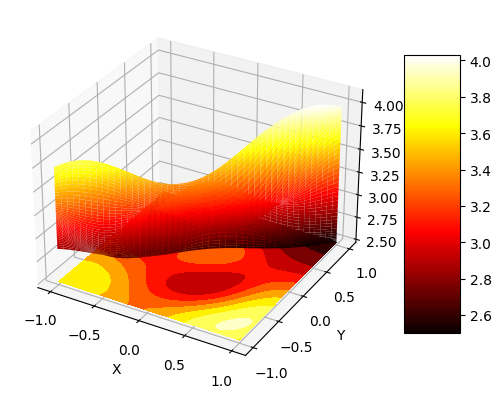

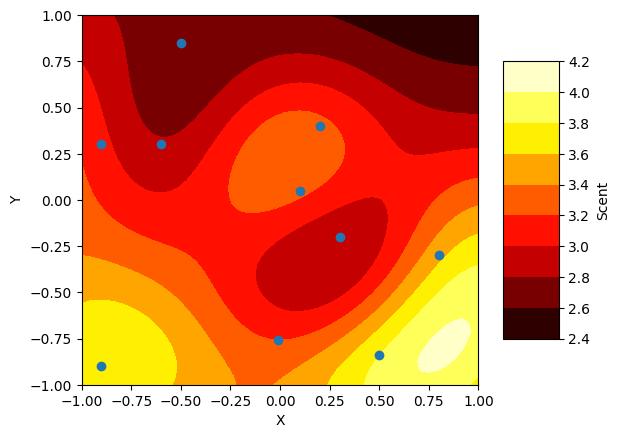

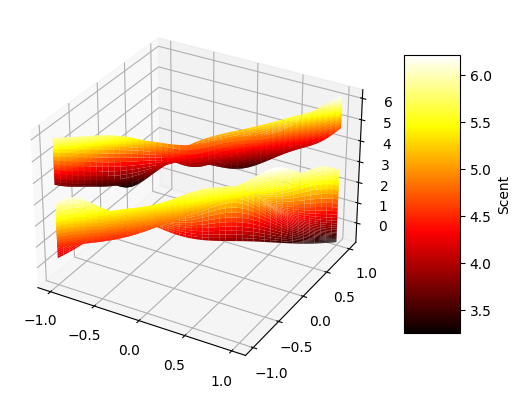

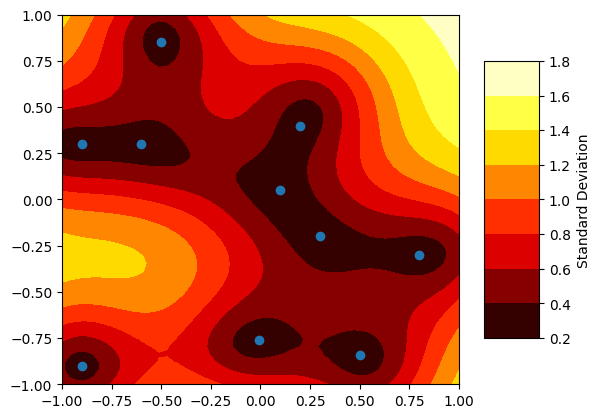

In [ ]:
pred_fstd_stage0 = np.sqrt(np.diag(cov_predict_stage0))
pred_fstd_stage0 = np.reshape(pred_fstd_stage0,(2500,1))
mean_predict_stage0_ = np.transpose(mean_predict_stage0.reshape(50,50))
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
my_cmap = plt.get_cmap('hot')
surf=ax.plot_surface(xpred, ypred, mean_predict_stage0_, cmap=my_cmap)
fig.colorbar(surf, ax = ax,shrink = 0.75, aspect = 5)
cset = ax.contourf(xpred, ypred, mean_predict_stage0_,
                   zdir ='z',
                   offset = np.min(mean_predict_stage0_),
                   cmap = my_cmap)
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Scent")
plt.show()

fig1 = plt.figure()
ax = fig1.add_subplot()
my_cmap = plt.get_cmap('hot')
plt.plot(input_pts[:,0], input_pts[:,1], 'o')
cset = ax.contourf(xpred, ypred, mean_predict_stage0_,
                   cmap = my_cmap)
fig.colorbar(cset, ax = ax,shrink = 0.75, aspect = 5, label="Scent")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

fig2 = plt.figure()
ax = fig2.add_subplot(projection="3d")
my_cmap = plt.get_cmap('hot')
surf=ax.plot_surface(xpred, ypred, np.reshape(mean_predict_stage0+2*pred_fstd_stage0, (50,50)).T, cmap=my_cmap)
surf2=ax.plot_surface(xpred, ypred, np.reshape(mean_predict_stage0-2*pred_fstd_stage0, (50,50)).T, cmap=my_cmap)
fig2.colorbar(surf, ax = ax,shrink = 0.75, aspect = 5, label="Scent")
plt.show()

fig4 = plt.figure()
ax = fig4.add_subplot()
cset = ax.contourf(xpred, ypred,  np.reshape(pred_fstd_stage0,(50,50)).T,
                   cmap = my_cmap)
fig4.colorbar(cset, ax = ax,shrink = 0.75, aspect = 5, label="Standard Deviation")
plt.plot(input_pts[:,0], input_pts[:,1], 'o')
plt.show()

In [ ]:
std_dev = np.reshape(pred_fstd_stage0,(50,50))

## Step 1 of Algorithm-Pick 4 points w highest variance
dist = 400
max_stddev = 0

for i in range(xpred.shape[0]):
  for j in range(ypred.shape[0]):
    if std_dev[i,j] > max_stddev:
      max_stddev = std_dev[i,j]
      max_stddev_pos = np.array([i,j])

max_stddev2 = 0

for i in range(xpred.shape[0]):
  for j in range(ypred.shape[0]):
    if (i-max_stddev_pos[0])**2+(j-max_stddev_pos[1])**2>dist:
      if std_dev[i,j] > max_stddev2:
        max_stddev2 = std_dev[i,j]
        max_stddev2_pos = np.array([i,j])

max_stddev3 = 0

for i in range(xpred.shape[0]):
  for j in range(ypred.shape[0]):
    if (i-max_stddev_pos[0])**2+(j-max_stddev_pos[1])**2>dist and (i-max_stddev2_pos[0])**2+(j-max_stddev2_pos[1])**2>dist:
      if std_dev[i,j] > max_stddev3:
        max_stddev3 = std_dev[i,j]
        max_stddev3_pos = np.array([i,j])

max_stddev4 = 0

for i in range(xpred.shape[0]):
  for j in range(ypred.shape[0]):
    if (i-max_stddev_pos[0])**2+(j-max_stddev_pos[1])**2>dist and (i-max_stddev2_pos[0])**2+(j-max_stddev2_pos[1])**2>dist and (i-max_stddev3_pos[0])**2+(j-max_stddev3_pos[1])**2>dist:
      if std_dev[i,j] > max_stddev4:
        max_stddev4 = std_dev[i,j]
        max_stddev4_pos = np.array([i,j])

input_pts_stage1 = np.array([[xpred[max_stddev_pos[0]], ypred[max_stddev_pos[1]]],[xpred[max_stddev2_pos[0]], ypred[max_stddev2_pos[1]]],[xpred[max_stddev3_pos[0]], ypred[max_stddev3_pos[1]]],[xpred[max_stddev4_pos[0]], ypred[max_stddev4_pos[1]]]])
print(input_pts_stage1)

[[ 1.          1.        ]
 [ 0.14285714  1.        ]
 [-1.         -0.30612245]
 [-1.          1.        ]]


In [ ]:
input_pts_stage1_ = np.vstack((input_pts, input_pts_stage1))
output_pts_stage1 = output_pts
output_train_stage1_ = np.array([3.695453542498009, 2.71967854578179, 3.545134056827534, 3.13972691399169])
output_train_stage1 = np.hstack((output_train, output_train_stage1_))

tau1_stage1_old = 1.3
tau2_stage1_old = 1.3
l1_stage1_old = 0.5
l2_stage1_old = 0.5
mean_prior_stage1_old = 2.5

mean_predict_stage1_old, cov_predict_stage1_old = gpr(input_pts_stage1_, output_train_stage1, output_pts_stage1, noise_cov * np.ones((input_pts_stage1_.shape[0])), mean_prior_stage1_old, sqexp, tau1_stage1_old, tau2_stage1_old, l1_stage1_old, l2_stage1_old)

mean_predict_stage1_old_ = np.transpose(mean_predict_stage1_old.reshape(50,50))
pred_fstd_stage1_old = np.sqrt(np.diag(cov_predict_stage1_old))
pred_fstd_stage1_old = np.reshape(pred_fstd_stage1_old,(2500,1))

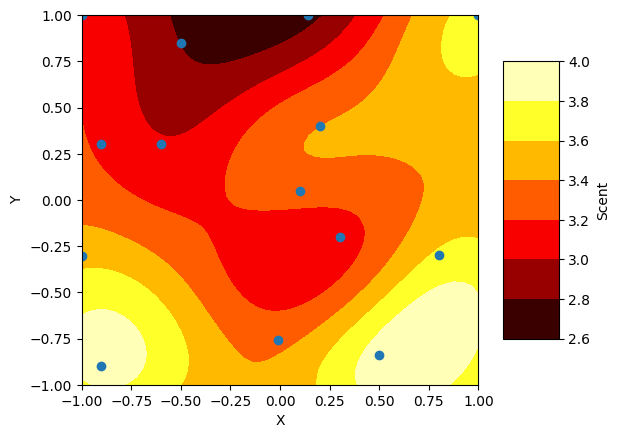

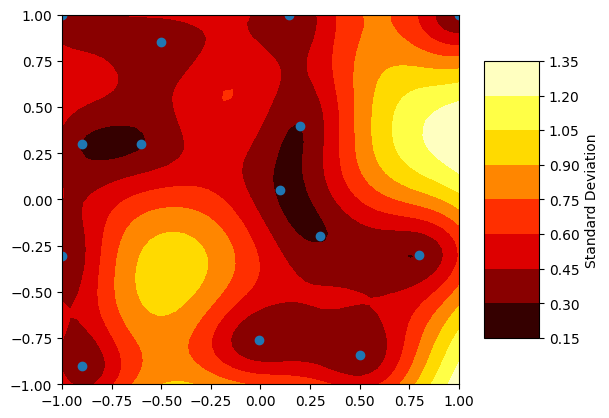

In [ ]:
fig_stage1_mean = plt.figure()
ax = fig_stage1_mean.add_subplot()
my_cmap = plt.get_cmap('hot')
cset = ax.contourf(xpred, ypred, mean_predict_stage1_old_,
                   cmap = my_cmap)
plt.plot(input_pts_stage1_[:,0], input_pts_stage1_[:,1], 'o')
fig.colorbar(cset, ax = ax,shrink = 0.75, aspect = 5, label="Scent")
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

fig_stage1_stddev = plt.figure()
ax = fig_stage1_stddev.add_subplot()
cset = ax.contourf(xpred, ypred,  np.reshape(pred_fstd_stage1_old,(50,50)).T,
                   cmap = my_cmap)
plt.plot(input_pts_stage1_[:,0], input_pts_stage1_[:,1], 'o')
fig4.colorbar(cset, ax = ax,shrink = 0.75, aspect = 5, label="Standard Deviation")
plt.show()

In [ ]:
tau1_stage1_new = 1.1
tau2_stage1_new = 1.1
l1_stage1_new = 0.45
l2_stage1_new = 0.45
mean_prior_stage1_new = 2

mean_predict_stage1_new, cov_predict_stage1_new = gpr(input_pts_stage1_, output_train_stage1, output_pts_stage1, noise_cov * np.ones((input_pts_stage1_.shape[0])), mean_prior_stage1_new, sqexp, tau1_stage1_new, tau2_stage1_new, l1_stage1_new, l2_stage1_new)

mean_predict_stage1_new_ = np.transpose(mean_predict_stage1_new.reshape(50,50))
pred_fstd_stage1_new = np.sqrt(np.diag(cov_predict_stage1_new))
pred_fstd_stage1_new = np.reshape(pred_fstd_stage1_new,(2500,1))


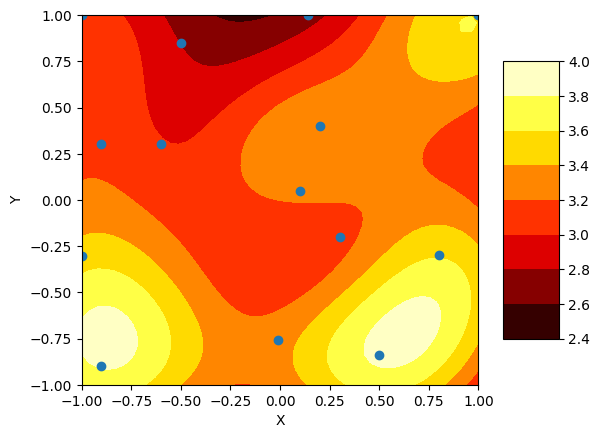

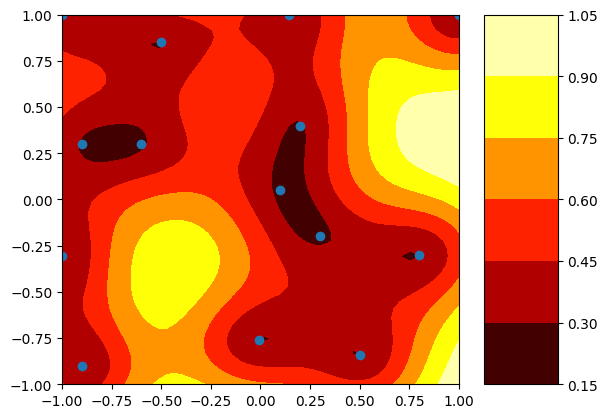

In [ ]:

fig_stage1_mean = plt.figure()
ax = fig_stage1_mean.add_subplot()
my_cmap = plt.get_cmap('hot')
cset = ax.contourf(xpred, ypred, mean_predict_stage1_new_,
                   cmap = my_cmap)
plt.plot(input_pts_stage1_[:,0], input_pts_stage1_[:,1], 'o')
fig.colorbar(cset, ax = ax,shrink = 0.75, aspect = 5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

fig_stage1_stddev = plt.figure()
ax = fig_stage1_stddev.add_subplot()
cset = ax.contourf(xpred, ypred,  np.reshape(pred_fstd_stage1_new,(50,50)).T,
                   cmap = my_cmap)
plt.plot(input_pts_stage1_[:,0], input_pts_stage1_[:,1], 'o')
fig4.colorbar(cset, ax = ax,shrink = 1, aspect = 5)
plt.show()

In [ ]:
def find_max_mean_scatter(mean_distribution, dist, xpred, ypred):

    max_mean1 = 0

    for i1 in range(xpred.shape[0]):
      for j1 in range(ypred.shape[0]):
        if mean_distribution[i1,j1] > max_mean1:
          max_mean1 = mean_distribution[i1,j1]
          max_m1_pos = np.array([i1,j1])

    max_mean2 = 0

    for i2 in range(xpred.shape[0]):
      for j2 in range(ypred.shape[0]):
        if (i2-max_m1_pos[0])**2+(j2-max_m1_pos[1])**2>dist:
          if mean_distribution[i2,j2] > max_mean2:
            max_mean2 = mean_distribution[i2,j2]
            max_m2_pos = np.array([i2,j2])

    max_mean3 = 0

    for i3 in range(xpred.shape[0]):
      for j3 in range(ypred.shape[0]):
        if (i3-max_m1_pos[0])**2+(j3-max_m1_pos[1])**2>dist and (i3-max_m2_pos[0])**2+(j3-max_m2_pos[1])**2>6*dist:
          if mean_distribution[i3,j3] > max_mean3:
            max_mean3 = mean_distribution[i3,j3]
            max_m3_pos = np.array([i3,j3])

    max_mean4 = 0

    for i4 in range(xpred.shape[0]):
      for j4 in range(ypred.shape[0]):
        if (i4-max_m1_pos[0])**2+(j4-max_m1_pos[1])**2>dist and (i4-max_m2_pos[0])**2+(j4-max_m2_pos[1])**2>6*dist and (i4-max_m3_pos[0])**2+(j4-max_m3_pos[1])**2>dist:
          if mean_distribution[i4,j4] > max_mean4:
            max_mean4 = mean_distribution[i4,j4]
            max_m4_pos = np.array([i4,j4])

    return np.array([[xpred[max_m1_pos[0]], ypred[max_m1_pos[1]]],[xpred[max_m2_pos[0]], ypred[max_m2_pos[1]]],[xpred[max_m3_pos[0]], ypred[max_m3_pos[1]]],[xpred[max_m4_pos[0]], ypred[max_m4_pos[1]]]])

input_pts_stage2 = find_max_mean_scatter(mean_predict_stage1_new_.T, 300, xpred, ypred)
print(input_pts_stage2)

[[ 0.63265306 -0.71428571]
 [-0.87755102 -0.75510204]
 [ 0.95918367  0.95918367]
 [ 0.3877551   0.42857143]]


In [ ]:
input_pts_stage2_ = np.vstack((input_pts_stage1_, input_pts_stage2))
output_pts_stage2 = output_pts
output_train_stage2_ = np.array([3.861464261881277, 3.8507822329704924,3.921350408594387,3.242618549112742])
output_train_stage2 = np.hstack((output_train_stage1, output_train_stage2_))

tau1_stage2_old = 1.1
tau2_stage2_old = 1.1
l1_stage2_old = 0.45
l2_stage2_old = 0.45
mean_prior_stage2_old = 2

mean_predict_stage2_old, cov_predict_stage2_old = gpr(input_pts_stage2_, output_train_stage2, output_pts_stage2, noise_cov * np.ones((input_pts_stage2_.shape[0])), mean_prior_stage2_old, sqexp, tau1_stage2_old, tau2_stage2_old, l1_stage2_old, l2_stage2_old)

In [ ]:
mean_predict_stage2_old_ = np.transpose(mean_predict_stage2_old.reshape(50,50))
pred_fstd_stage2_old = np.sqrt(np.diag(cov_predict_stage2_old))
pred_fstd_stage1_old = np.reshape(pred_fstd_stage1_old,(2500,1))

fig_stage2_mean = plt.figure()
ax = fig_stage2_mean.add_subplot()
my_cmap = plt.get_cmap('hot')
cset = ax.contourf(xpred, ypred, mean_predict_stage2_old_,
                   cmap = my_cmap)
plt.plot(input_pts_stage2_[:,0], input_pts_stage2_[:,1], 'o')
fig.colorbar(cset, ax = ax,shrink = 0.75, aspect = 5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

fig_stage2_stddev = plt.figure()
ax = fig_stage2_stddev.add_subplot()
cset = ax.contourf(xpred, ypred,  np.reshape(pred_fstd_stage2_old,(50,50)).T,
                   cmap = my_cmap)
plt.plot(input_pts_stage2_[:,0], input_pts_stage2_[:,1], 'o')
fig4.colorbar(cset, ax = ax,shrink = 1, aspect = 5)
plt.show()

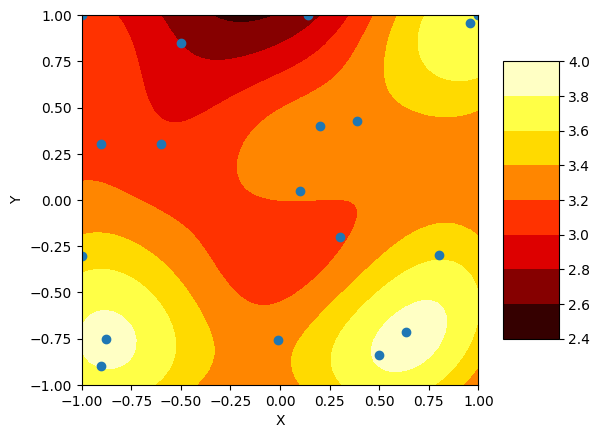

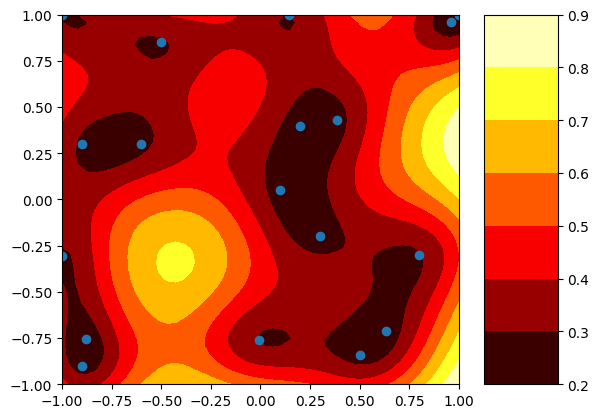

In [ ]:
tau1_stage2_new = 1.1
tau2_stage2_new = 1.1
l1_stage2_new = 0.5
l2_stage2_new = 0.5
mean_prior_stage2_new = 2

mean_predict_stage2_new, cov_predict_stage2_new = gpr(input_pts_stage2_, output_train_stage2, output_pts_stage2, noise_cov * np.ones((input_pts_stage2_.shape[0])), mean_prior_stage2_new, sqexp, tau1_stage2_new, tau2_stage2_new, l1_stage2_new, l2_stage2_new)

mean_predict_stage2_new_ = np.transpose(mean_predict_stage2_new.reshape(50,50))
pred_fstd_stage2_new = np.sqrt(np.diag(cov_predict_stage2_new))
pred_fstd_stage2_new = np.reshape(pred_fstd_stage2_new,(2500,1))

fig_stage2_mean = plt.figure()
ax = fig_stage2_mean.add_subplot()
my_cmap = plt.get_cmap('hot')
cset = ax.contourf(xpred, ypred, mean_predict_stage2_new_,
                   cmap = my_cmap)
plt.plot(input_pts_stage2_[:,0], input_pts_stage2_[:,1], 'o')
fig.colorbar(cset, ax = ax,shrink = 0.75, aspect = 5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

fig_stage2_stddev = plt.figure()
ax = fig_stage2_stddev.add_subplot()
cset = ax.contourf(xpred, ypred,  np.reshape(pred_fstd_stage2_new,(50,50)).T,
                   cmap = my_cmap)
plt.plot(input_pts_stage2_[:,0], input_pts_stage2_[:,1], 'o')
fig4.colorbar(cset, ax = ax,shrink = 1, aspect = 5)
plt.show()

In [ ]:
input_pts_stage3 = find_max_mean_scatter(mean_predict_stage2_new_.T, 50, xpred, ypred)
for i in range(input_pts_stage3.shape[0]):
  for j in range(input_pts_stage2.shape[0]):
    if input_pts_stage3[i,0] == input_pts_stage2[j,0] and input_pts_stage3[i,1] == input_pts_stage2[j,1]:
      input_pts_stage3[i,:] = np.array([input_pts_stage3[i,0]+0.05, input_pts_stage3[i,1]+0.05])
print(input_pts_stage3)
input_pts_stage3_ = np.vstack((input_pts_stage2_, input_pts_stage3))
output_pts_stage3 = output_pts
output_train_stage3_ = np.array([3.9684467848617504, 3.6307528282050967, 3.6427848725473853, 4.219525560491045])
output_train_stage3 = np.hstack((output_train_stage2, output_train_stage3_))

[[ 0.63265306 -0.75510204]
 [-0.82755102 -0.70510204]
 [ 0.79591837 -0.51020408]
 [ 0.95918367  0.91836735]]


In [ ]:
tau1_stage3_old = 1.1
tau2_stage3_old = 1.1
l1_stage3_old = 0.5
l2_stage3_old = 0.5
mean_prior_stage3_old = 2

mean_predict_stage3_old, cov_predict_stage3_old = gpr(input_pts_stage3_, output_train_stage3, output_pts_stage3, noise_cov * np.ones((input_pts_stage3_.shape[0])), mean_prior_stage3_old, sqexp, tau1_stage3_old, tau2_stage3_old, l1_stage3_old, l2_stage3_old)

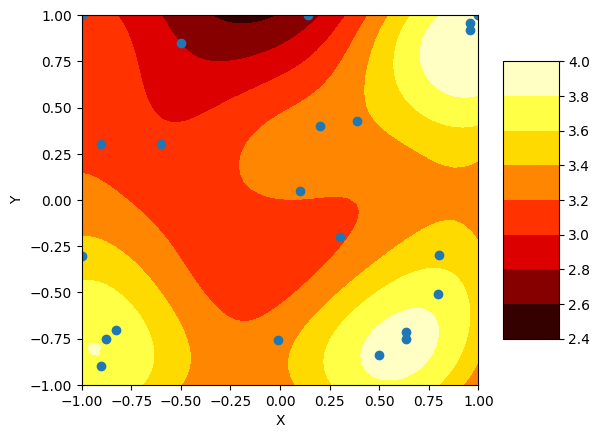

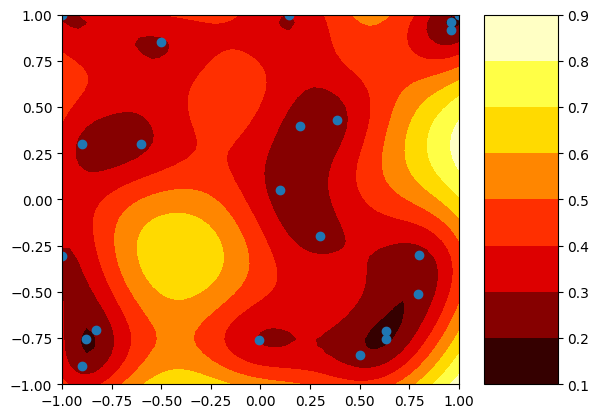

In [ ]:
mean_predict_stage3_old_ = np.transpose(mean_predict_stage3_old.reshape(50,50))
pred_fstd_stage3_old = np.sqrt(np.diag(cov_predict_stage3_old))
pred_fstd_stage3_old = np.reshape(pred_fstd_stage3_old,(2500,1))

fig_stage3_mean = plt.figure()
ax = fig_stage3_mean.add_subplot()
my_cmap = plt.get_cmap('hot')
cset = ax.contourf(xpred, ypred, mean_predict_stage3_old_,
                   cmap = my_cmap)
plt.plot(input_pts_stage3_[:,0], input_pts_stage3_[:,1], 'o')
fig.colorbar(cset, ax = ax,shrink = 0.75, aspect = 5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

fig_stage2_stddev = plt.figure()
ax = fig_stage2_stddev.add_subplot()
cset = ax.contourf(xpred, ypred,  np.reshape(pred_fstd_stage3_old,(50,50)).T,
                   cmap = my_cmap)
plt.plot(input_pts_stage3_[:,0], input_pts_stage3_[:,1], 'o')
fig4.colorbar(cset, ax = ax,shrink = 1, aspect = 5)
plt.show()

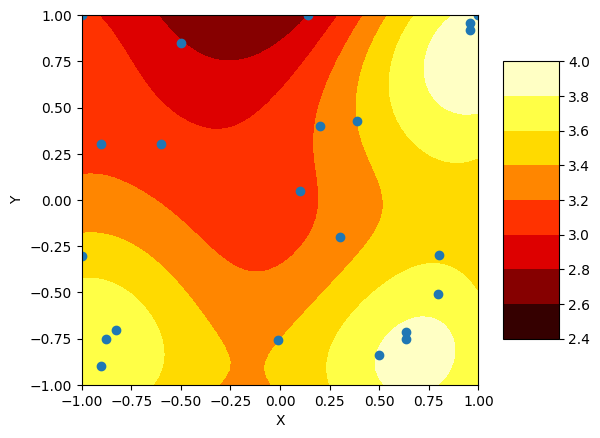

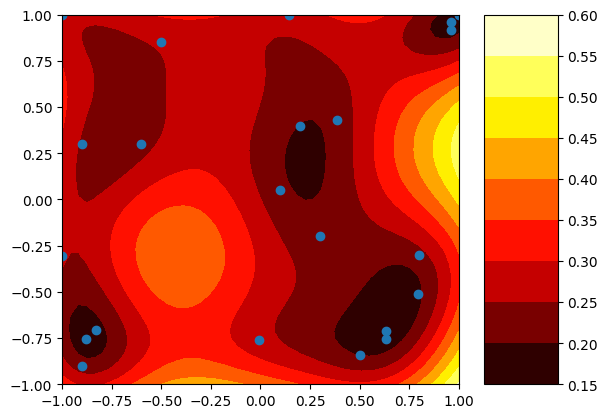

In [ ]:
tau1_stage3_new = 1
tau2_stage3_new = 1
l1_stage3_new = 0.65
l2_stage3_new = 0.65
mean_prior_stage3_new = 2

mean_predict_stage3_new, cov_predict_stage3_new = gpr(input_pts_stage3_, output_train_stage3, output_pts_stage3, noise_cov * np.ones((input_pts_stage3_.shape[0])), mean_prior_stage3_old, sqexp, tau1_stage3_new, tau2_stage3_new, l1_stage3_new, l2_stage3_new)

mean_predict_stage3_new_ = np.transpose(mean_predict_stage3_new.reshape(50,50))
pred_fstd_stage3_new = np.sqrt(np.diag(cov_predict_stage3_new))
pred_fstd_stage3_new = np.reshape(pred_fstd_stage3_new,(2500,1))

fig_stage3_mean = plt.figure()
ax = fig_stage3_mean.add_subplot()
my_cmap = plt.get_cmap('hot')
cset = ax.contourf(xpred, ypred, mean_predict_stage3_new_,
                   cmap = my_cmap)
plt.plot(input_pts_stage3_[:,0], input_pts_stage3_[:,1], 'o')
fig.colorbar(cset, ax = ax,shrink = 0.75, aspect = 5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

fig_stage2_stddev = plt.figure()
ax = fig_stage2_stddev.add_subplot()
cset = ax.contourf(xpred, ypred,  np.reshape(pred_fstd_stage3_new,(50,50)).T,
                   cmap = my_cmap)
plt.plot(input_pts_stage3_[:,0], input_pts_stage3_[:,1], 'o')
fig4.colorbar(cset, ax = ax,shrink = 1, aspect = 5)
plt.show()

In [ ]:
max_scent = 0

for ii in range(xpred.shape[0]):
  for jj in range(ypred.shape[0]):
    if mean_predict_stage3_new_.T[ii,jj] > max_scent:
      max_scent = mean_predict_stage3_new_.T[ii,jj]
      max_s_pos = np.array([ii,jj])


loc_object = np.array([xpred[max_s_pos[0]], ypred[max_s_pos[1]]])
print(max_scent, loc_object)

3.9384902088768925 [1.         0.79591837]


In [ ]:
def monte_carlo_smell_problem(num_samples, sample_generator, g_evaluator, mean_distribution, std_dev_distribution, xpred, ypred,cumsum=False):
    """Perform Monte Carlo sampling

    Inputs
    ------
    num_samples: integer, number of samples
    sample_generator: A function that generates samples with signature sample_generator(nsamples)
    g_evaluator: a function that takes as inputs the samples and outputs the evaluations.
                 The outputs can be any dimension, however the first dimension should have size *num_samples*
    cumsum: Boolean, an option to return estimators of all sample sizes up to num_samples

    Returns
    -------
    A Monte Carlo estimator of the mean, samples, and evaluations
    """
    samples = sample_generator(num_samples, mean_distribution, std_dev_distribution, xpred, ypred)
    evaluations = g_evaluator(samples)
    if cumsum is False:
        estimate =  np.sum(evaluations, axis=0) / float(num_samples)
    else:
        estimate = np.cumsum(evaluations, axis=0) / np.arange(1,num_samples+1, dtype=np.float)

    return estimate, samples, evaluations

def surface_max_generator(num_samples, mean_distribution, std_dev_distribution, xpred, ypred):

  surface_max_loc = np.zeros((num_samples,2))

  for k in range(num_samples):
    max_scent = 0
    surface = np.zeros(mean_distribution.shape)
    for i in range(xpred.shape[0]):
      for j in range(ypred.shape[0]):
        surface[i,j] = np.random.randn()*std_dev_distribution[i,j]+mean_distribution[i,j]
    for ii in range(surface.shape[0]):
      for jj in range(surface.shape[1]):
        scent = surface[ii,jj]
        if scent>max_scent:
          max_scent = scent
          max_scent_pos = np.array([xpred[ii], ypred[jj]])
    surface_max_loc[k,:] = max_scent_pos

  return surface_max_loc

def indicator_in_region(surface_max_loc):

    result = np.zeros((surface_max_loc.shape[0],1))

    for k in range(surface_max_loc.shape[0]):
      x = surface_max_loc[k,0]
      y = surface_max_loc[k,1]

      if x>=0.7 and x<=1 and y>=0.5 and y<=0.9:
        result[k,0] = 1
      else:
        result[k,0] = 0

    return result

std_dev_stage3 = np.reshape(pred_fstd_stage3_new,(50,50)).T
num_samples = 100000

estimate_prob, samples, evals = monte_carlo_smell_problem(num_samples, surface_max_generator, indicator_in_region, mean_predict_stage3_new_.T, std_dev_stage3, xpred, ypred)

print(estimate_prob)

[0.24851]


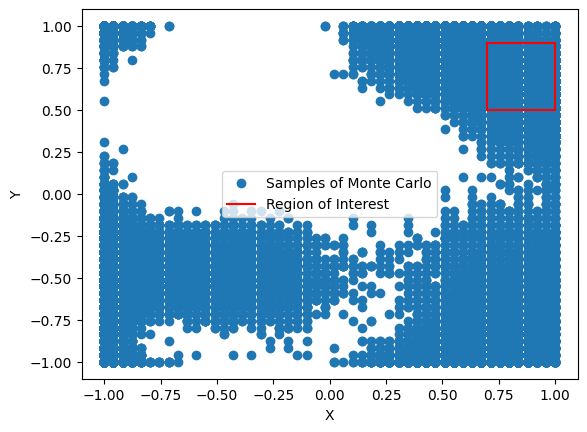

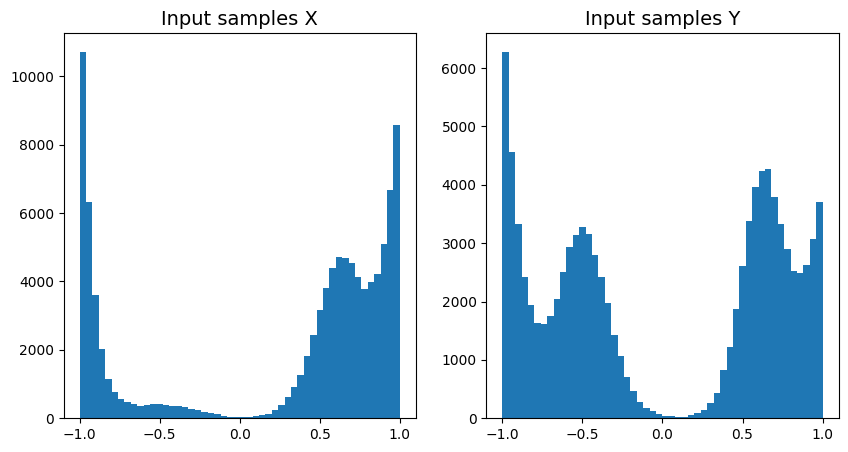

In [ ]:
plt.figure()
plt.plot(samples[:,0], samples[:,1], 'o')
plt.plot([0.7,1],[0.5,0.5],"r")
plt.plot([0.7,1],[0.9,0.9],"r")
plt.plot([0.7,0.7],[0.5,0.9],"r")
plt.plot([1,1],[0.5,0.9],"r")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend(["Samples of Monte Carlo", "Region of Interest"])
plt.show()

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].hist(samples[:,0], bins=50)
axs[0].set_title("Input samples X", fontsize=14)
axs[1].hist(samples[:,1], bins=50)
axs[1].set_title("Input samples Y", fontsize=14)
plt.show()

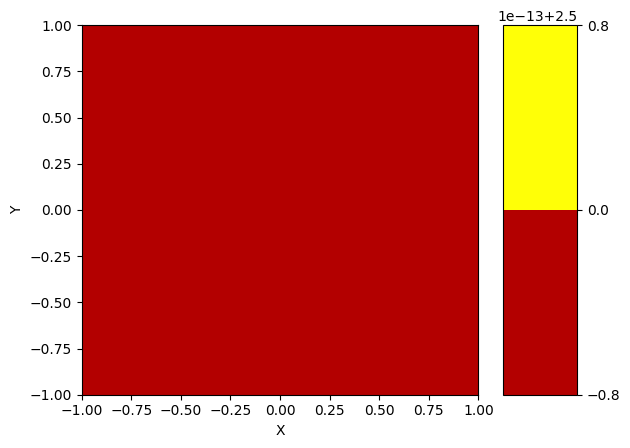

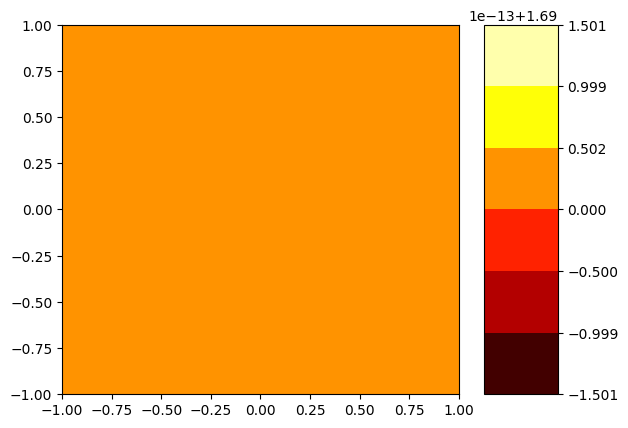

In [ ]:
mean_prior = 2.5*np.ones((50,50))
cov_prior = build_covariance(output_pts, output_pts, sqexp, 1.3, 1.3, 0.5, 0.5)
std_dev_prior = np.sqrt(np.diag(cov_prior))
std_dev_prior = np.reshape(std_dev_prior,(2500,1))


fig_prior_mean = plt.figure()
ax = fig_prior_mean.add_subplot()
my_cmap = plt.get_cmap('hot')
cset = ax.contourf(xpred, ypred, mean_prior,
                   cmap = my_cmap)
fig.colorbar(cset, ax = ax,shrink = 1, aspect = 5)
ax.set_xlabel("X")
ax.set_ylabel("Y")
plt.show()

fig_prior_stddev = plt.figure()
ax = fig_prior_stddev.add_subplot()
cset = ax.contourf(xpred, ypred,  np.reshape(std_dev_prior,(50,50)).T,
                   cmap = my_cmap)
fig4.colorbar(cset, ax = ax,shrink = 1, aspect = 5)
plt.show()

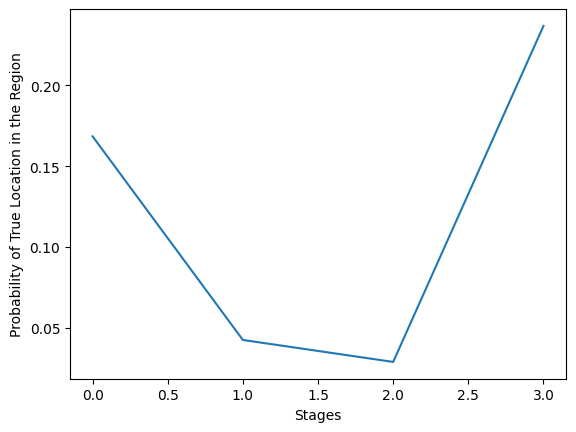

In [ ]:
num_samples = 10000
estimate_prob_0, samples, evals = monte_carlo_smell_problem(num_samples, surface_max_generator, indicator_in_region, mean_predict_stage0_.T, np.reshape(pred_fstd_stage0,(50,50)).T, xpred, ypred)
estimate_prob_1, samples, evals = monte_carlo_smell_problem(num_samples, surface_max_generator, indicator_in_region, mean_predict_stage1_new_.T, np.reshape(pred_fstd_stage1_new,(50,50)).T, xpred, ypred)
estimate_prob_2, samples, evals = monte_carlo_smell_problem(num_samples, surface_max_generator, indicator_in_region, mean_predict_stage2_new_.T,  np.reshape(pred_fstd_stage2_new,(50,50)).T, xpred, ypred)
estimate_prob_3, samples, evals = monte_carlo_smell_problem(num_samples, surface_max_generator, indicator_in_region, mean_predict_stage3_new_.T,  np.reshape(pred_fstd_stage3_new,(50,50)), xpred, ypred)

stages = np.array([0,1,2,3])
probs = np.array([estimate_prob_0, estimate_prob_1, estimate_prob_2, estimate_prob_3])

plt.figure()
plt.plot(stages, probs)
plt.xlabel("Stages")
plt.ylabel("Probability of True Location in the Region")
plt.show()